# Eye Fixation Prediction in Digital Images

Benjamin Jafek <br>
Dec 14, 2017

# TODO
1. Figure out formatting (McKell?)
2. Proofread (3am lol)

# 1. Introduction

In [77]:
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
import numpy as np
import background_functions as bf

&emsp; It has been suggested that "eighty to eighty five percent of [human] perception, learning, cognition and activities are mediated through vision" (Thomas Politzer, Former Neuro-Optimetric Rehabilitation Association (NORA) President). Since so much of what we understand about the world comes from visual inputs, humans have become very good at seeing. For this specific project, I am interested in how humans filter out unnecessary visual input and focus on the most information-salient locations in a given image. I will use low-level image information such as brightness, contrast, and focus measure as predictors for eye fixations. This approach has biological corroboration; scientific exploration has shown that human visual processes use both bottom-up and top-down representations of visual input [1]. <br>
&emsp; The figure below shows a heatmap of where people fixated their eyes on an image of a locker room: how did all of the observers decide that the sports bag on the ground was something worth looking at? How did they decide *not* to fixate on each inch of the floor? It is questions like these that I will explore more deeply in this study.

In [129]:
#Read in data
df = pd.read_csv('Scene Viewing Fix Report.txt', delimiter='\t')

#The X and Y locations must be adjusted, since they are calibrated to 
# the edge of the monitor which was displaying the images, not the 
# images themselves.
df['CURRENT_FIX_X'] -= 400
df['CURRENT_FIX_Y'] -= 150
df = df[(df['CURRENT_FIX_X'] <= 800) & (df['CURRENT_FIX_X'] >= 0) &
        (df['CURRENT_FIX_Y'] <= 600) & (df['CURRENT_FIX_Y'] >= 0)]

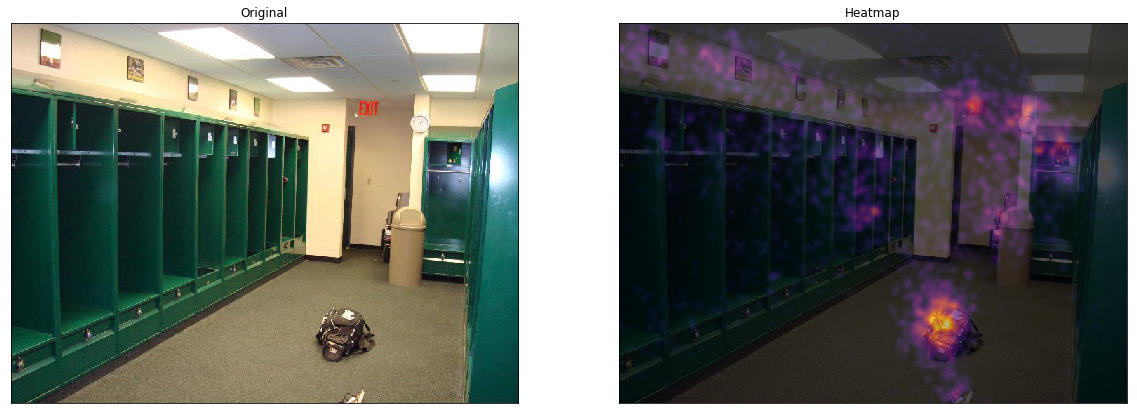

In [3]:
#Heatmap
chosen_image = 'lockerroom4.jpg'
img = plt.imread(chosen_image) 

dfheatmap = df[df['picture']==chosen_image]
x, y = dfheatmap['CURRENT_FIX_X'].values, dfheatmap['CURRENT_FIX_Y'].values

#Make heatmap
intensity = np.zeros([600,800])
for ind, xpoint in enumerate(x):
    ypoint = y[ind]
    intensity[int(ypoint), int(xpoint)] += 1
#This Gaussian blur changes the intensity matrix 
# from a bunch of points to a nice heatmap.
intensity = cv2.GaussianBlur(intensity, (27,27), 0)

#Display
plt.figure(figsize=(20,16))
titles = ['Original', 'Heatmap']
for i in range(1,3):
    plt.subplot(1,2,i)
    plt.imshow(img)
    if i==2:
        plt.imshow(intensity, alpha=0.7, cmap='inferno')
    plt.title(titles[i-1])
    plt.yticks([])
    plt.xticks([])
plt.show()

&emsp; Results from this study will be very interesting for two main reasons. First, it is an important step in understanding how the human brain works. Cognitive scientists are very interested in developing a deeper understanding of how the human brain works; in this sense, visual attention modeling is itself a reasonable end goal. On a deeper level, neuroscientists seek to understand the low-level neural bases for the higher level cognitive processes that we can observe in behavior. Thus, this modeling is also a stepping stone towards understanding the deeper neuronal activity of the brain. Second, these models could be used to inform machine vision algorithms. Machine vision is an active area of research in computer science. Human and primate visual models have proven to be helpful in improving computer vision techniques [2, 3, 4]. I anticipate that results from this project will benefit computer vision research.

# 2. Data

&emsp; As a proxy for visual attention, I chose to use eye-tracking data. This has been shown to be a very effective representation of visual attention [5, 6, 7]. I received a dataset from Dr. Steven Luke in the BYU Psychology department. He is very interested in modeling human visual attention, and had just collected eyetracking data on a series of images when I met him. The data consisted of columns including fixation and image information. I discarded columns which described factors either uninteresting or beyond the scope of my project, such as "current blink" or "saccade peak velocity", retaining only those columns directly related to which pixels the person focused on. A random sample of the data that he collected is shown below.

In [4]:
df = df[['picture', 'CURRENT_FIX_X', 'CURRENT_FIX_Y']]
print ('Total valid fixations: {:,}.\n'.format(len(df)))
print (df.sample(5))

Total valid fixations: 120,468.

                     picture  CURRENT_FIX_X  CURRENT_FIX_Y
71276              slum2.jpg          170.4           21.5
26079           carnival.jpg          277.8          519.5
111339     butchers_shop.jpg           74.3          245.1
118547  basketballcourt5.jpg          366.5          231.9
25996           FOUNTAIN.jpg          511.7          134.6


&emsp; There were 33 unique images, each 600x800 pixels, capturing scenes from slums to oceans to computer labs. To define localized areas of eye fixations, I split each image into 768 images of 25x25 pixels each. The conversion rate of pixels to millimeters is about 3.77 pixels per millimeter, so each localized image corresponds to an image of about 40 square millimeters. Thus, although the sample size of 103 volunteers and the image count of 33 were both very small, the dataset I generated consisted of 25,344 images and 120,468 total valid fixations recorded. This sample size is large enough to make reasonable conclusions about the data gathered.  
&emsp; The eye fixations were captured at the BYU Eye Tracking Lab, using the Eyelink 100 Plus system from SR Research [8]. This machine is reported to be accurate within 2-5 millimeters (8-18 pixels), so the localized images are large enough that the majority of eye fixations will be recorded in the correct box.  
&emsp; The goal of this project is to discover which low-level features of the image correlate most strongly with eye fixations (i.e., draw the most attention of the eye). X and Y locations may be correlated with fixations; for example, people tend to focus on the center of images. However, this surely does not account for all of the attention-allocating process. Thus, I gathered many low-level properties of the localized images to use as features in my model.

# 3. Feature Engineering

&emsp; I hypothesize that the following low-level features influence where in an image a person will decide to look: brightness, contrast, focus measure [9], and color. Focus measure is a quantification of clarity: lower numbers correspond to more blurry images, while higher numbers correspond to more clear images. This number is represented as the variance of the image after applying a Laplacian convolution (shown below) [10]. <br>
&emsp; Previous work has shown that mammalian visual cortices react differently to different orientations of lines [11]. Thus, I also look at the contrast and focus measure of only the horizontal and vertical lines in the image. This is made possible through the use of a Sobel edge detector, for both the x and the y direction (shown below) [10].

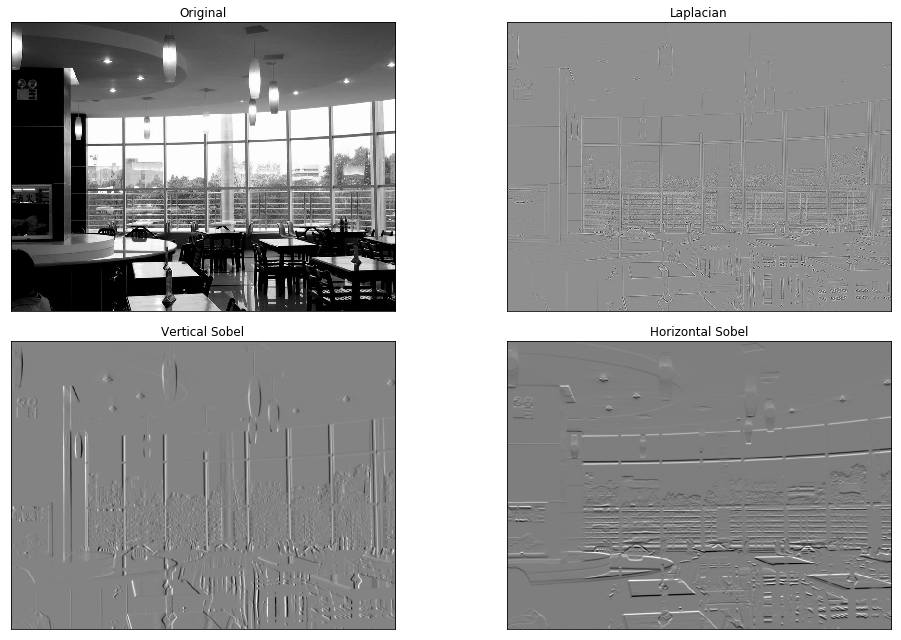

In [5]:
img = plt.imread('diningroom.jpg')
img = img.mean(axis=2) #B&W

plt.figure(figsize=(15,9))

#Gradient filter
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

titles = ['Original', 'Laplacian', 'Vertical Sobel', 'Horizontal Sobel']
for ind, picture in enumerate([img, laplacian, sobelx, sobely]):
    plt.subplot(2,2,ind+1)
    plt.imshow(picture, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[ind])
plt.tight_layout()
plt.show()


&emsp; After applying the necessary preprocessing techniques, the 12 features of each localized image which I have captured are the following:
1. **Red proportion:** Sum of the red pixel channel, divided by the sum of all pixels in the image.
2. **Green proportion:** Sum of the green pixel channel, divided by the sum of all pixels in the image.
3. **Blue proportion:** Sum of the blue pixel channel, divided by the sum of all pixels in the image (notice that Red+Green+Blue=1.0 for each individual localized image). 
4. **Brightness:** The naive calculation of brightness would be to just take the mean pixel value of the grayscaled image. However, the colors red, green, and blue correspond to different brightnesses (a fully red image would be perceived as more bright than a fully blue image). Thus, we use the mean Luma value, a formula borrowed from video processing, to calculate the brightness of the image. The formula for luma is the following: $$Y=0.2126R+0.7152G+0.0722B$$
The mean value of the 2D array Y is calculated to give us the brightness. <br><br> <br>
After the color proportion and brightness features are extracted, the image is converted to grayscale for the calculation of the remaining features. <br> <br> <br>
5. **Contrast:** Contrast has a number of different definitions, each advantageous in different situations. In our case, since the images are so large, and therefore have high variance between pixel values, I have chosen to use the root mean square (RMS) contrast, given in the formula below:
$$\sqrt{\frac{1}{M N}\sum_{i=0}^{N-1}\sum_{j=0}^{M - 1}(I_{ij} - \bar{I})^2},$$
where intensities ${\displaystyle I_{ij}} I_{{ij}}$ are the ${\displaystyle i}$-th and ${\displaystyle j}$-th element of the two-dimensional image of size ${\displaystyle M}$ by ${\displaystyle N}$. ${\displaystyle {\bar {I}}}$ is the average intensity of all pixel values in the image.
6. **Horizontal Contrast:** This is the RMS contrast of the horizontal image, filtered using the horizontal Sobel edge detector.
7. **Vertical Contrast:** This is the RMS contrast of the vertical image, filtered using the horizontal Sobel edge detector.
8. **Focus measure:** Focus measure also has a variety of different definitions [2], the majority being based on either pixel statistics, autocorrelation of pixels, data compression, or value gradients. For this study, we use the definition of the variance of the Laplacian image (see above). This is a value gradient focus measure: the Laplacian operator leaves the image with only strong edges, so the more strong edges the image has, the more in-focus it is likely to be.
9. **Horizontal Focus Measure:** same as (8), on horizontally filtered Sobel edge detector.
10. **Vertical Focus Measure:** Sam as (8), on vertically filtered Sobel edge detector.
11. **X location:** The X-coordinate of the eye fixation. This value is between 0 and 800, binned into one of the 768 localized images --- thus the X-coordinate is binned into one of 32 potential locations (800 pixels / 25 pixels per localized image).
12. **Y location:** The Y-coordinate of the eye fixation. This value is between 0 and 600, binned into one of the 24 different localized image y-coordinates.  <br> <br>

13. **Fixation (label):** The fixation count increments for each eye fixation which falls in the localized image. Thus, the 120,468 total recorded eye fixations were distributed among the localized images. Some images had as many as 1,232 individual fixations, or as few as 0.

These features were saved in a CSV file 15 columns wide (including all features, and 2 identification columns) and 24,576 rows long. 5 randomly sampled rows are shown below. Notice that the features have not yet been normalized, so that we can more intuitively understand the numbers. When we input these features into machine learning models to try to predict eye fixations, these columns will be normalized.

In [7]:
df_full = pd.read_csv('fixation_report.csv')
print (df_full.sample(5))

                            picture      Blue  Brightness   Contrast  \
8336   basketballcourt5_475_425.jpg  0.318725  145.200016   9.698325   
3180        herb_garden_300_425.jpg  0.285268   95.029096  31.508882   
22979  football_stadium_375_200.jpg  0.350365   63.820621  27.316259   
20109            closet_125_500.jpg  0.233553  135.540824  12.322289   
14689       video_store_350_375.jpg  0.319515  180.293968  50.320947   

                FM     Green  HorizContrast       HorizFM       Red  \
8336    246.906407  0.351536     505.547558  5.596002e+05  0.329739   
3180   3172.768469  0.412258    1249.897514  2.709178e+06  0.302474   
22979   560.912896  0.290322     917.970412  6.318806e+05  0.359312   
20109  3917.731059  0.322917     193.008694  1.410797e+05  0.443530   
14689  6760.385196  0.336520    1721.486664  4.724336e+06  0.343965   

       VertContrast        VertFM    X    Y     short_picture  Fixation  
8336     229.775249  6.700453e+04  475  425  basketballcourt5     

# 4. Analysis

### 4.1 Distribution of Features

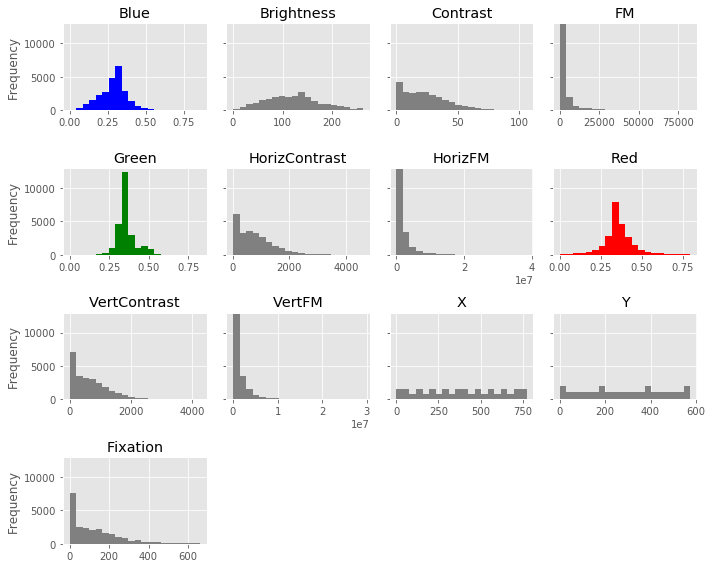

In [74]:
plt.figure(figsize=(25,20))
plt.figure(figsize=(10,8))
bf.color_plot(df_full)
plt.show()

&emsp; Many of these histograms are uninteresting: for example, X and Y are uniformly distributed (except for binning miscalculations), as should be expected since that how the dataset was generated. Also, red, green, blue, and brightness are all normally distributed around moderate values. This makes sense, given the visual complexity of the images.  
&emsp; Of note, however, are the histograms pertaining to fixations and the different types of contrasts and focus measures. First, notice that fixations look almost like a zipf distribution ($f(r)∝\frac{1}{r^{α}}$). This is promising, since it means that a few localizations are receiving a large portion of the total fixations: there is something that the people are looking at. Second, the contrasts and focus measures also seem to represent a zipf distribution with a higher alpha value. This similarity between the contrast/focus measure distributions and the fixation distribution suggests that these are going to be the factors which draw visual attention.

### 4.2 Fixation Affectors
&emsp; The following bar charts have each divided different features into 10-quantiles. This means that each bar represents the same number of localized images, so if the eye fixations were uniformly distributed across all posisble locations in the observed images, each bar would be the same length. The actual difference between bar lengths will allow us to observe how different factors affected visual attention.

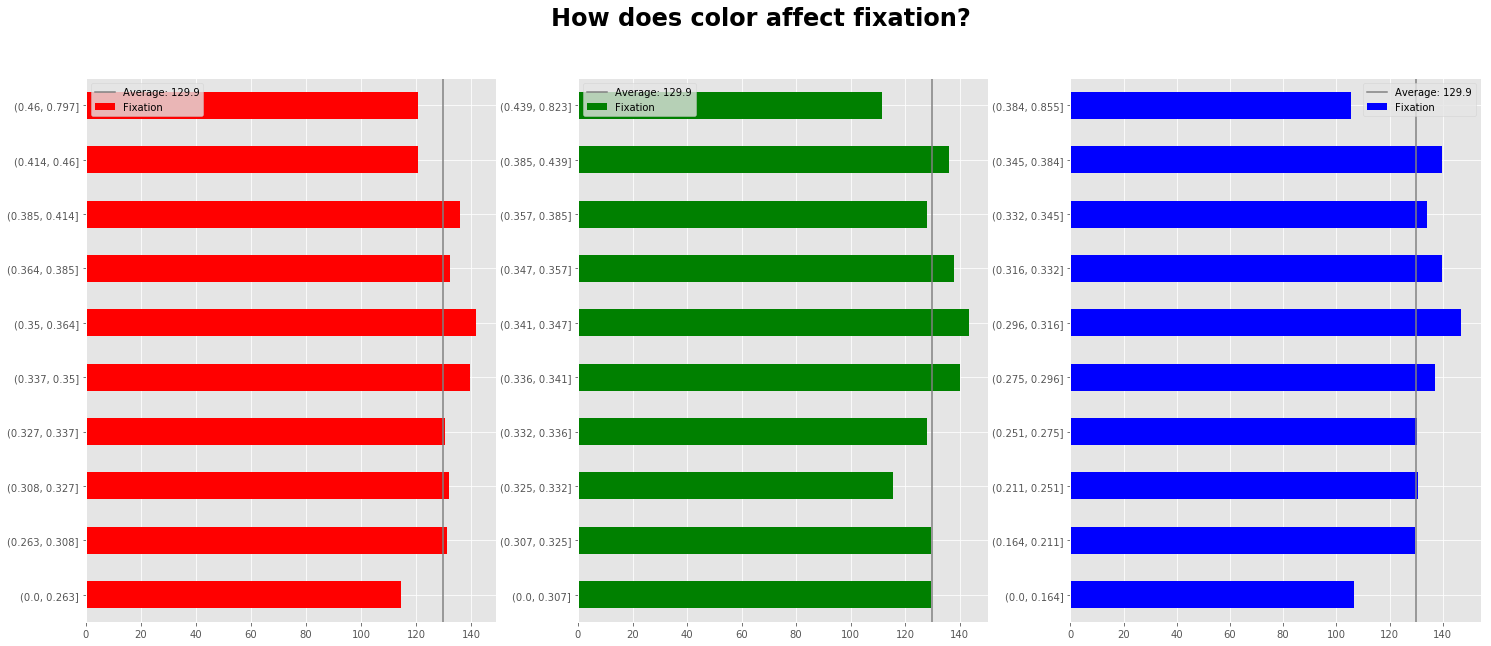

In [71]:
bf.fixation_and_color(df_full)
plt.show()

&emsp; Notice in this graph that fixations loosely follow a normal distribution around the center for each color. This suggests that visually appealing locations correspond to locations where many colors are represented, which relates to all of the RGB color channels being combined together.

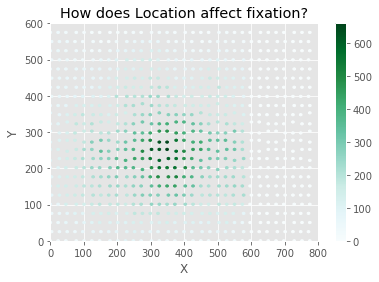

In [128]:
bf.fixation_and_location(df_full)
plt.show()

&emsp; In the graph above, the green boxes represent the fixation count. Notice that the majority of the fixations are clustered near the center of the image. This makes sense: people tend to focus their attention on the center of the image, since that is traditionally where the important information is located. Photographers usually seek to keep the important subjects of their photographs near the middle portion of the image.  
&emsp; In the case of this dataset, the fixations tend slightly to the left and down of true center, which the point (400,300). This is likely just an oddity of the particular 33 images we chose. This eccentricity suggests that while centrality is important, it is not the most important allocator of attention. This finding is consistent with our original hypothesis.  
&emsp; We proceed by looking to focus measure as an affector of visual attention.

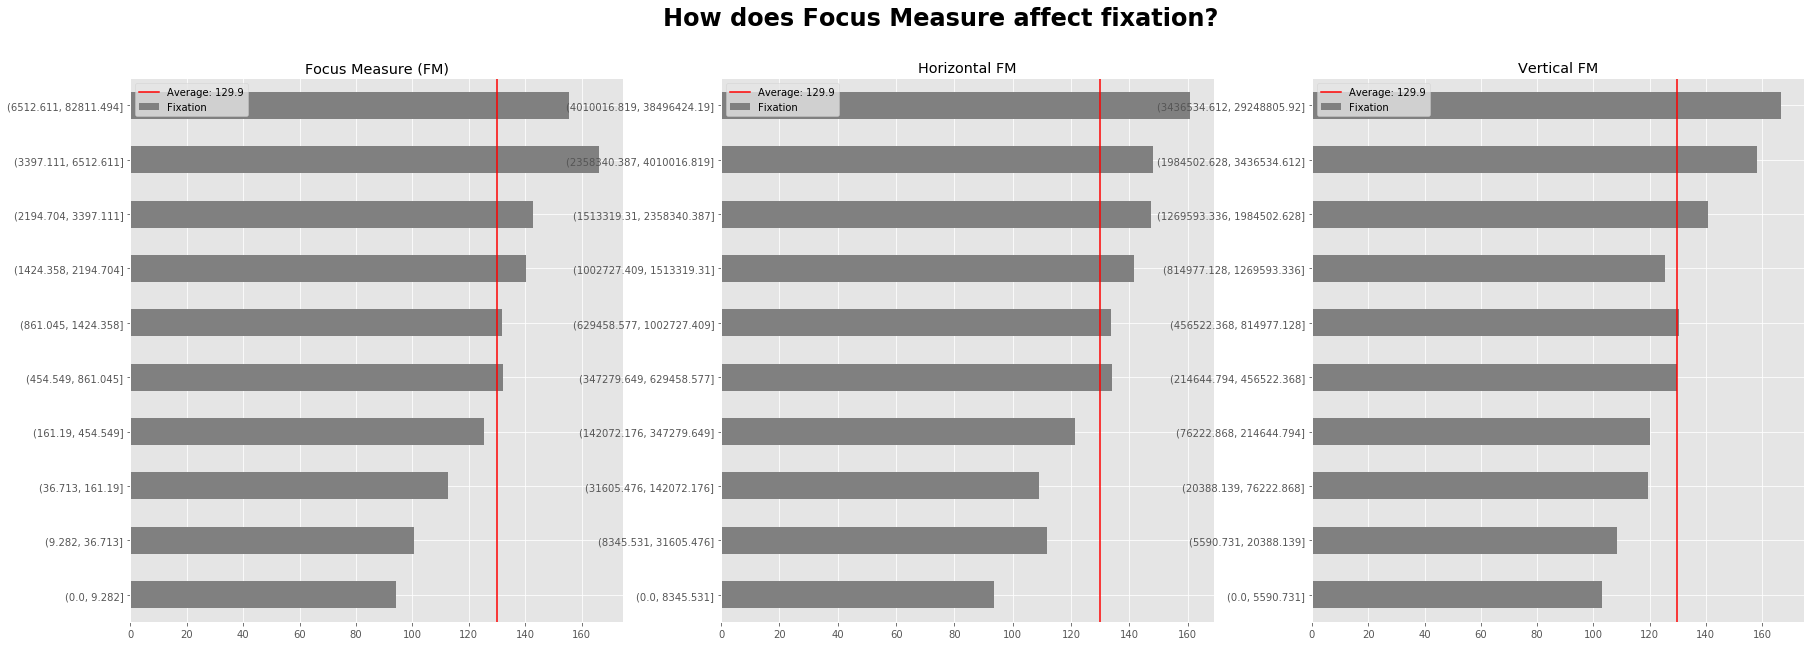

In [104]:
bf.fixation_and_focus_measures(df_full)
plt.show()

&emsp; Notice that the number of fixations is nearly monotonically increasing as a function of focus measure, for all of the measures. This suggests that crisp images attract the gaze of observers. This clarity may also be associated with pixel values which vary more widely (see 'How does Contrast affect Fixation?', below). We notice a slight improvement in this slope for vertical focus measure, which suggests that vertical lines are the most important in calling visual attention.  
&emsp; Interestingly enough, this phenomenon has biological justification: in 1981, neurophysiologists David Hubel and Torsten Wiesel at Johns Hopkins University were awarded the Nobel Prize in Physiology for their discovery that mammalian brains respond differently to different orientations of visual input [11]. This discovery has become the flagship of modern vision research, and served as inspiration for the computer vision method of texture analysis known as Gabor filtering [10].  
&emsp; Next, we explore how contrast affects the visual attention.

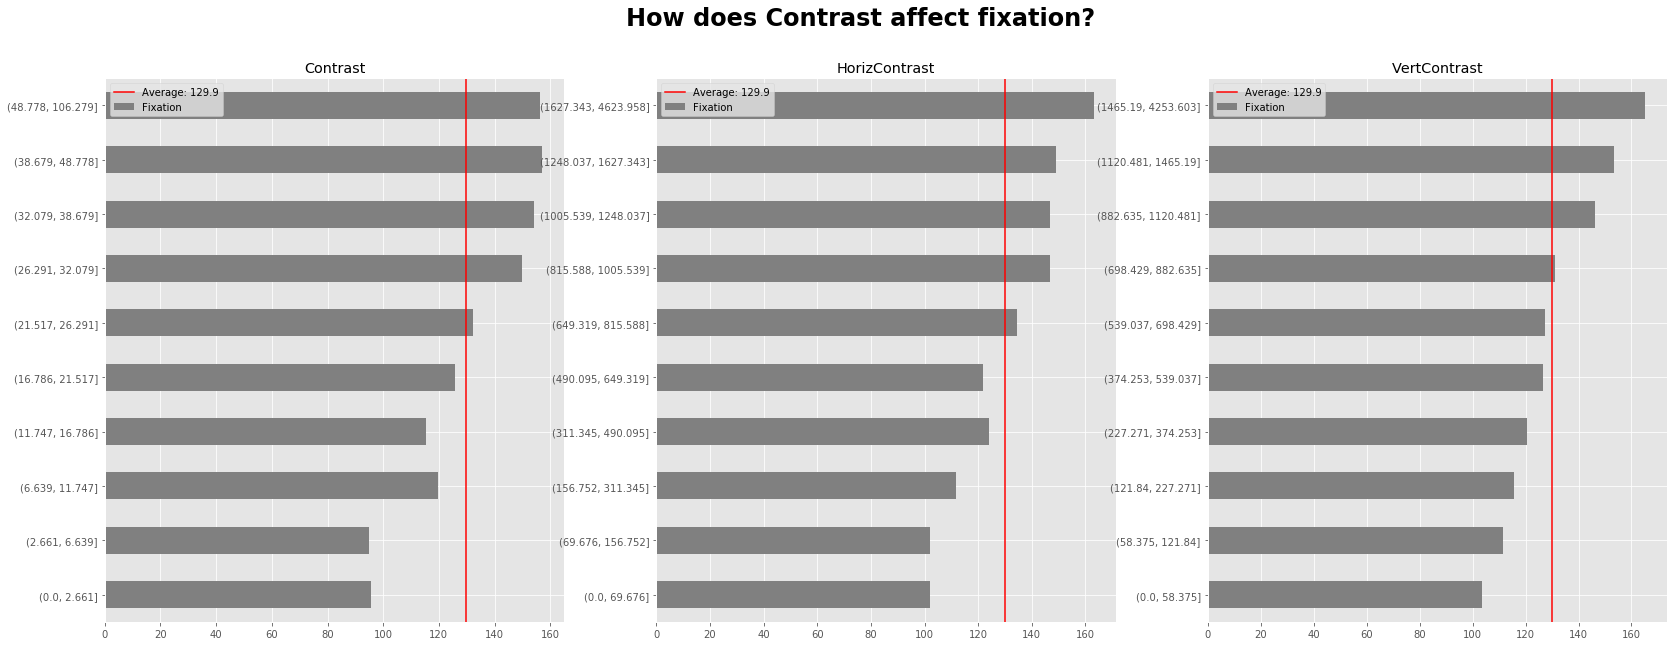

In [95]:
bf.fixation_and_contrasts(df_full)
plt.show()

&emsp; Notice again that fixation is nearly monotonically increasing as a function of contrast, with a sharper slope on vertical contrast. This was hinted at by the focus measure graph, and has now been confirmed. Intuitively, it makes sense that observers focus more of their attention on the locations in the image where there is more contrast: more contrast means more pixels are changing in those locations, so it must be interesting. Recall the previous example of the sports bag on the floor of the locker room: the designs, straps, and equipment of the sports bag will surely have more contrast than the uniform tiles of the floor. These results suggest that contrast is a good low-level indicator of where a person will look in a given image.

# 5. Conclusion
### 5.1 Summary
&emsp; This study has statistically explored the extent to which low-level information about an image$-$ namely color, brightness, contrast, and focus measure$-$ affect visual attention. We discovered that the locations of an image which will tend to have most fixations will be near the center of the image, at locations of moderate brightness, with high focus measure and contrast. The most important indicator of visual attention seems to be contrast on the vertical lines in the image, though further work will be necessary to declare this conclusively, due to the small size of the dataset.
### 5.2 Future Work
&emsp; Future work will further explore these discrepancies which have been discovered here. It would be useful to obtain more images and more eye-tracking data, so that the suggestions that have been developed in this study can be more confidently concluded.
&emsp; This dataset is well-poised for machine learning models to be applied to it. Ideally, machine learning algorithms such as deep learning will be able to exploit these discrepancies to generate a model that can accurately predict eye fixations in images. If such a model proves to exist, then this research will be invaluable to both cognitive scientists and computer vision researchers. In computer vision specifically, this type of model can be used to assist detection and recognition algorithms in filtering out unnecessary visual information, to speed them up. We are excited to see what this vein of research can offer.

# 6. Sources

1. F W M Stentiford, "Visual attention: low level and high level viewpoints," Optics, Photonics & Digital Technologies for Multimedia, Proc SPIE vol. 8436, April 2012.
2. Kruger, N. et al. "Deep Hierarchies in the Primate Visual Cortex: What Can We Learn for Computer Vision?" _IEEE Transactions on Pattern Analysis and Machine Intelligence_ 35 (8). 2013.
3. Sinha, P., Balas, B., Ostrovsky, Y., and Russell, R. "Face Recognition by Humans: Nineteen Results All Computer Vision Researchers Should Know About," _Proceedings of the IEEE_ 94 (11). 2006.
4. Bolduc, M., and Levine, M. "A Review of Biologically Motivated Space-Variant Data Reduction Models for Robotic Vision" _Computer Vision and Image Understanding_ 69 (2): 170-184. 1998.
5. Hoffman, J. and Subramaniam, B. "The role of visual attention in saccadic eye movements." _Perception and Psychophysics_ 57. 6 (1995): 787-795.
6. P. Reinagel and A.M. Zador, “The Effect of Gaze on Natural Scene Statistics,” _Neural Information and Coding Workshop_, Snowbird, Utah, 16-20 Mar. 1997.
7. Liu, H. and Heynderickx, I. "Visual Attention in Objective Image Quality Assessment: Based on Eye-Tracking Data." _IEEE Transactions on Circuits and Systems for Video Technology_ 21 (7). 2011.
8. http://www.sr-research.com/ <br>
9. Pertuz, S., Puig, D., and Garcia, M. "Analysis of focus measure operators for shape-from-focus." _Pattern Recognition_, 2013. <br>
10. Szeliski, Richard. *"Computer Vision: Algorithms and Applications"* Springer, 2010. Draft.
11. Hubel, D., and Wiesel, T. "The period of susceptibility to the physiological effects of unilateral eye closure in kittens." *The Journal of Physiology"* 206 (2). 1970. <br>